In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt

## Visualization

[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0 101  86 101  96  98 108
 125  83 100 102   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0  88  99  98  93 104 115  98 102 106  97   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]


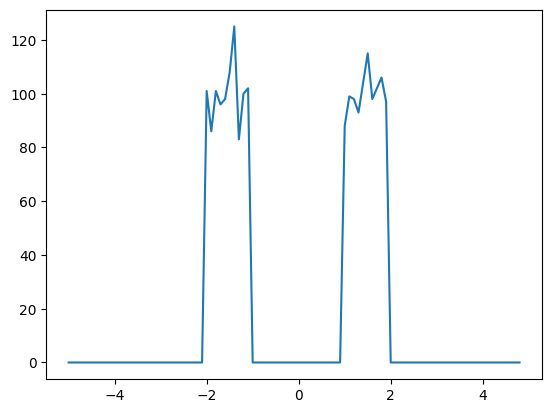

In [2]:
# 원본 분포

# 각 구간의 범위 설정
a1, b1 = 1, 2   # 첫 번째 구간
a2, b2 = -2, -1   # 두 번째 구간

# 각 구간에서 균일 분포 샘플 생성
n_samples_1 = 1000  # 첫 번째 구간에서 생성할 샘플 수
n_samples_2 = 1000  # 두 번째 구간에서 생성할 샘플 수

samples_1 = np.random.uniform(a1, b1, n_samples_1)
samples_2 = np.random.uniform(a2, b2, n_samples_2)

# 두 구간에서의 샘플을 합침
combined_samples = np.concatenate([samples_1, samples_2])

x, bins = np.histogram(combined_samples, bins=np.linspace(-5, 5, 100, endpoint=False))

print(x)
# plt.plot(combined_samples)
plt.plot(bins[:-1], x)
plt.show()

In [3]:
def forward_single_step(samples, beta_t):
    forward_samples = []
    for sample in combined_samples:
        forward_sample = np.random.normal(loc=np.sqrt(1 - beta_t) * sample, scale=beta_t)
        forward_samples.append(forward_sample)

    return forward_samples

In [4]:
# forward process
total_steps = 30
forward_samples_list = [combined_samples]
forward_hist_list = []

# forward
for t in range(1, total_steps+1):
    beta_t = t/total_steps

    forward_result = forward_single_step(forward_samples_list[t-1], beta_t=t/total_steps)
    forward_samples_list.append(forward_result)

print(len(forward_samples_list))

# histogram
for samples in forward_samples_list:
    x, bins = np.histogram(samples, bins=np.linspace(-5, 5, 100, endpoint=False))

    forward_hist_list.append((x, bins))

print(len(forward_hist_list))

31
31


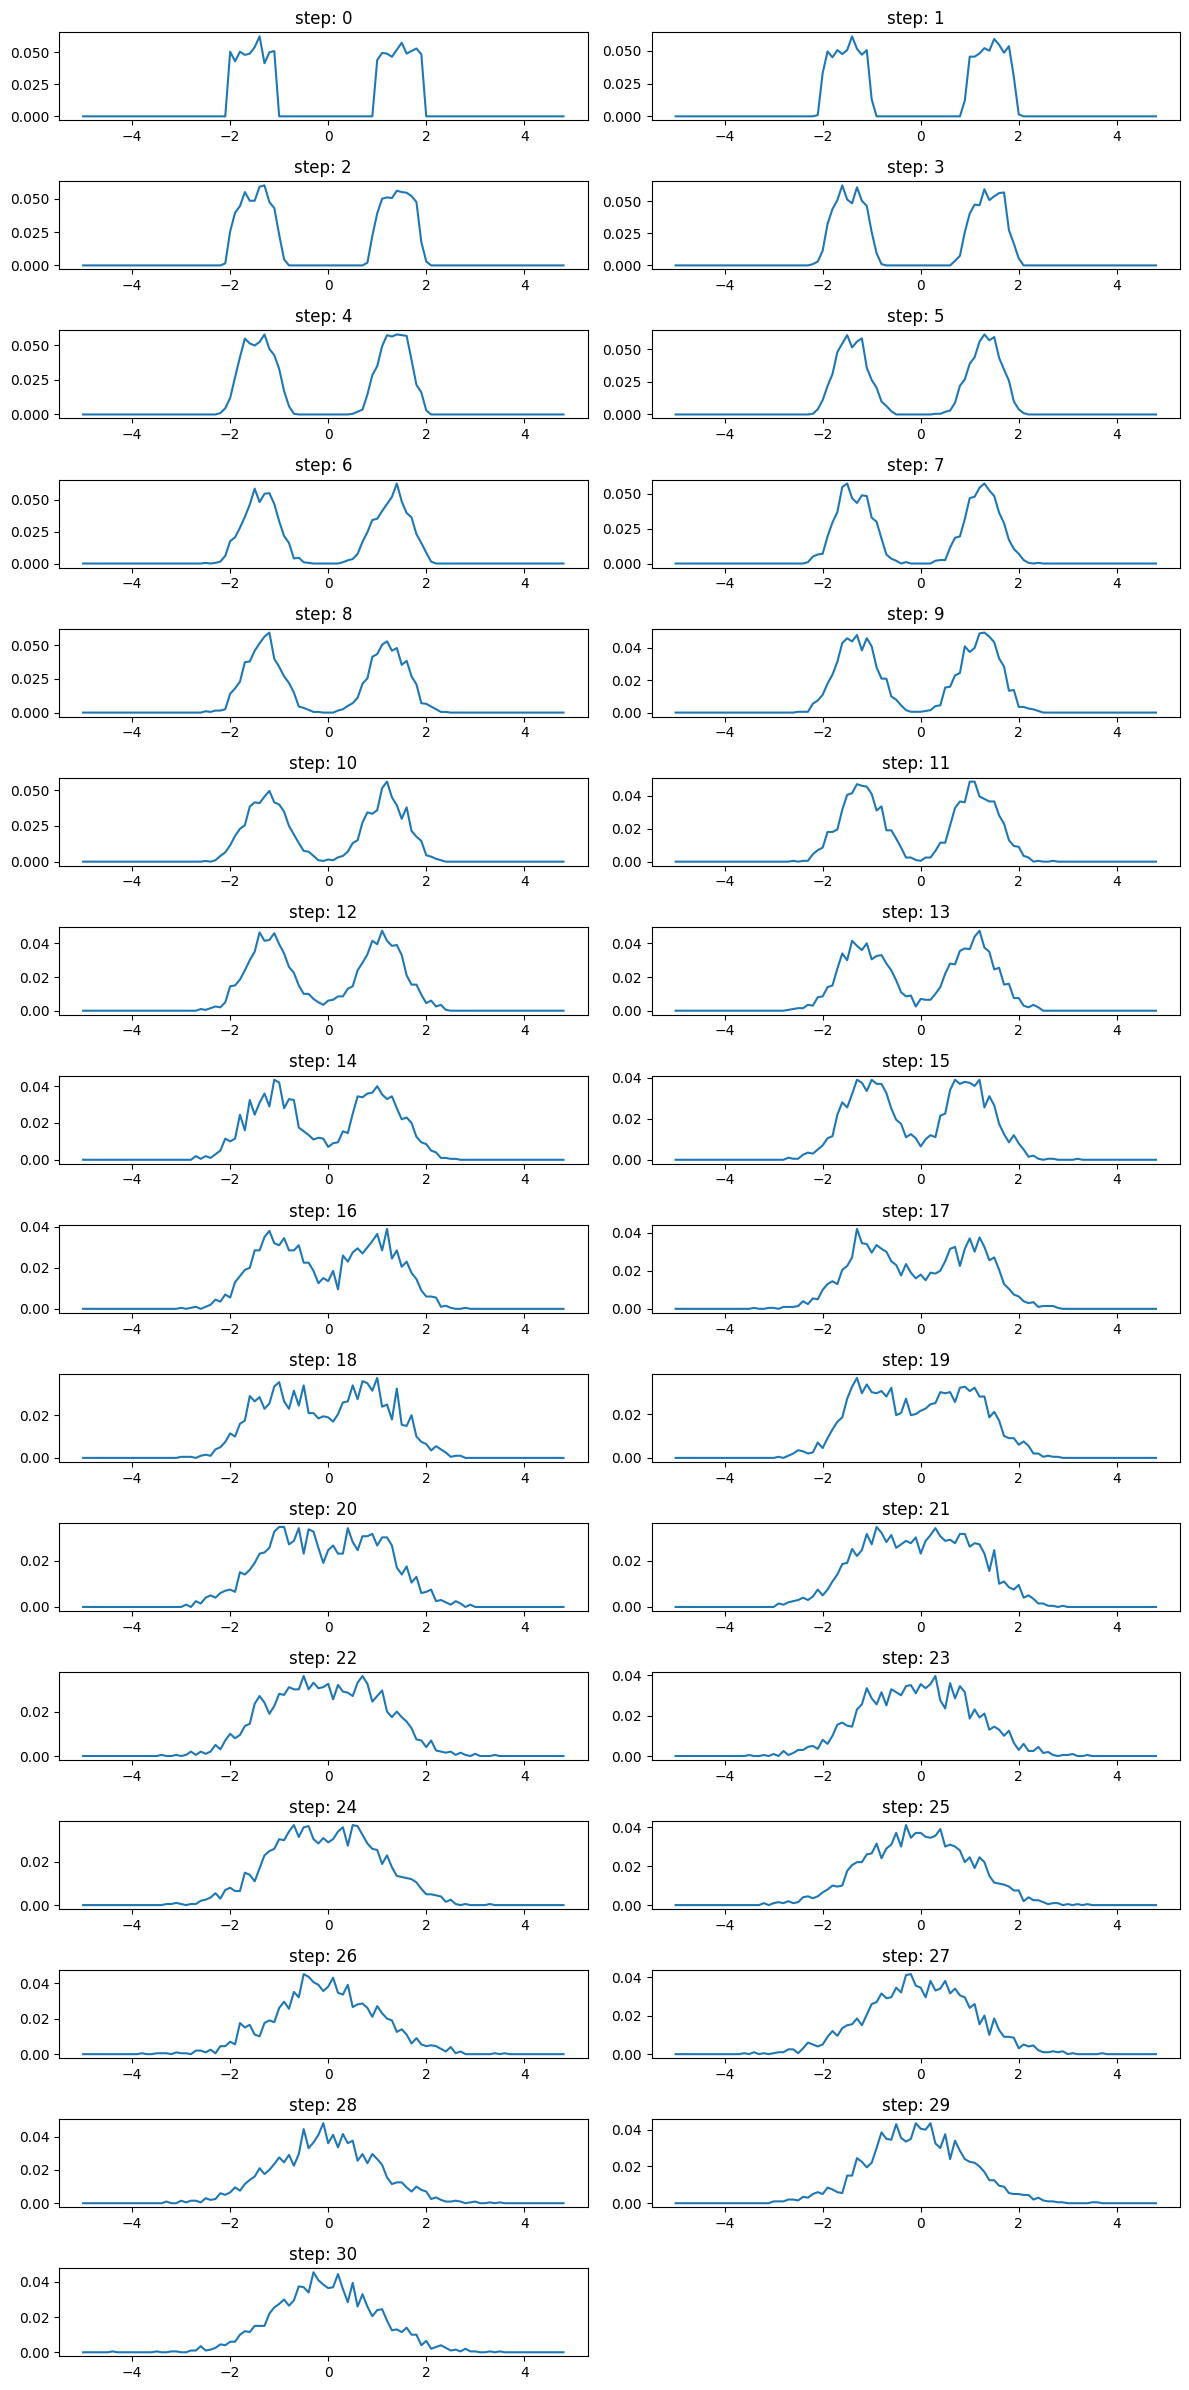

In [5]:
# Plot
plt.figure(figsize=(12, 24))

cols = 2
rows = np.ceil(total_steps/cols).astype(int) + 1

for i, samples_hist in enumerate(forward_hist_list):
    x, bins = samples_hist

    plt.subplot(rows,cols,i+1)
    plt.title(f"step: {i}")
    plt.plot(bins[:-1], x/np.sum(x))

plt.tight_layout()
plt.show()

31


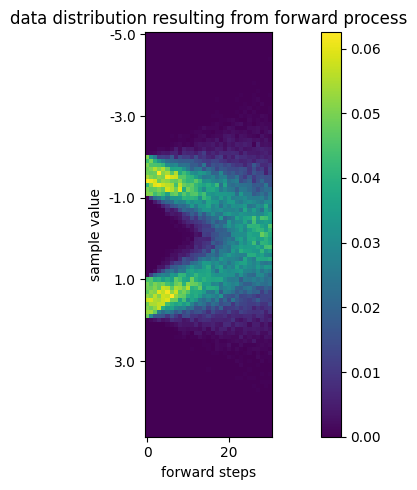

In [6]:
forward_hist_values = []
for samples_hist in forward_hist_list:
    x, bins = samples_hist
    # normalize
    x = x/np.sum(x)

    forward_hist_values.append(x)
print(len(forward_hist_values))

stacked_image = np.repeat(np.array(forward_hist_values), 1, axis=0)
stacked_image_show = stacked_image.T

plt.figure(figsize=(10, 5))
plt.title("data distribution resulting from forward process")
plt.imshow(stacked_image_show)
plt.yticks(ticks=np.arange(0, stacked_image_show.shape[0], 20), labels=bins[:-1:20])
plt.xlabel("forward steps")
plt.ylabel("sample value")
plt.colorbar()
plt.tight_layout()
plt.show()

## Train

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

device = 'cuda'
print("device:", device)

device: cuda


In [8]:
# alpha, beta etc.
beta_t = np.arange(1, total_steps+1) / total_steps
alpha_t = 1 - beta_t

alpha_bar_t = np.multiply.accumulate(alpha_t)
one_alpha_bar_t = 1 - alpha_bar_t
sqrt_alpha_bar_t = np.sqrt(alpha_bar_t)
sqrt_one_alpha_bar_t = np.sqrt(one_alpha_bar_t)

alpha_bar_t = torch.from_numpy(alpha_bar_t).to(device)
one_alpha_bar_t = torch.from_numpy(one_alpha_bar_t).to(device)
sqrt_alpha_bar_t = torch.from_numpy(sqrt_alpha_bar_t).to(device)
sqrt_one_alpha_bar_t = torch.from_numpy(sqrt_one_alpha_bar_t).to(device)


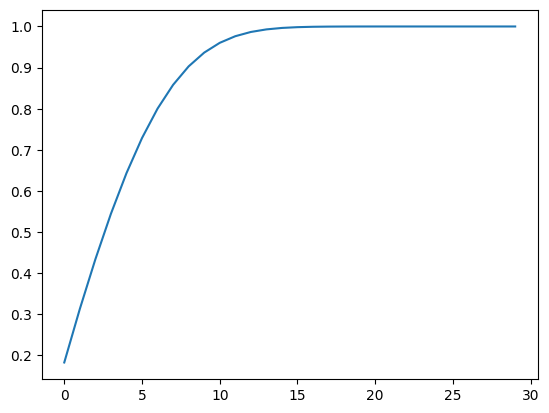

In [9]:
plt.plot(sqrt_one_alpha_bar_t.detach().cpu().numpy())
plt.show()

In [13]:
# Network
class DiffusionModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.time_encoder = nn.Sequential(
                                nn.Linear(1, 3),
                                nn.ReLU(),
                                nn.Linear(3,1)
                                )

        self.data_encoder = nn.Sequential(
                                nn.Linear(1, 3),
                                nn.ReLU(),
                                nn.Linear(3,1)
                                )

    def forward(self, x, t):
        out = self.data_encoder(x) + self.time_encoder(t)
        out = F.sigmoid(out)

        return out

model = DiffusionModel()
model = model.to(device)

In [14]:
# prepare training
optimizer = optim.Adam(model.parameters())
criterion = nn.MSELoss()

In [15]:
# Train
batch_size = 8
num_epochs = 10
losses = []

for epoch in range(num_epochs):
    print("epoch:", epoch)
    data_pool = combined_samples.copy()

    # normalize
    data_pool = F.sigmoid(torch.from_numpy(data_pool))

    while (len(data_pool) > 0):
        # data
        data = np.random.choice(data_pool, batch_size, replace=False)
        data_pool = np.setdiff1d(data_pool, data)

        # preprocess
        # random noise
        ts = torch.randint(0, total_steps, [batch_size]).type(torch.float).to(device)
        noised_data = []
        eps = torch.randn([batch_size, 1]).to(device)
        for i in range(len(ts)):
            time_step = ts[i].type(torch.int)

            noised_data.append(sqrt_alpha_bar_t[time_step] * data[i] + sqrt_one_alpha_bar_t[time_step] * eps[i])
        noised_data = torch.stack(noised_data, dim=0).to(device)

        ts = ts.reshape(-1, 1)
        noised_data = noised_data.reshape(-1, 1)

        # forward
        # print("noised_data.shape:", noised_data.shape)
        # print("ts.shape:", ts.shape)
        e_hat = model(noised_data, ts)

        # loss
        loss = criterion(eps, e_hat)
        losses.append(loss.item())

        # optimizer step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()



epoch: 0
epoch: 1
epoch: 2
epoch: 3
epoch: 4
epoch: 5
epoch: 6
epoch: 7
epoch: 8
epoch: 9


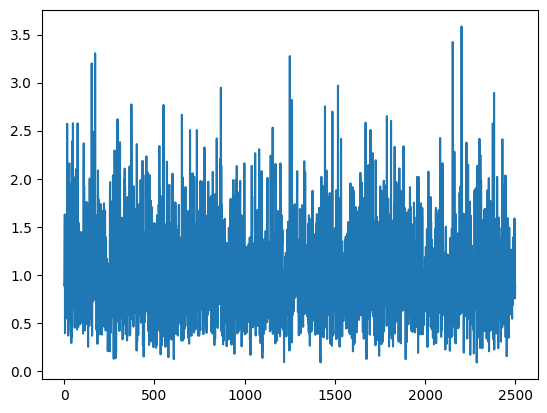

In [16]:
plt.plot(losses)

In [166]:
len(losses)
print(losses[-3])

0.8595172166824341


## Sampling

In [17]:
num_samples = 100
generated_samples = []

# data
noise = torch.randn([num_samples, 1]).to(device)
noise = F.sigmoid(noise)

# denoising
# sample_steps = torch.arange(total_steps-2, 0, -1).type(torch.float)
sample_steps = torch.arange(10, 0, -1).type(torch.float).to(device)
x = noise
for t in sample_steps:
    with torch.no_grad():
        if t > 1:
            z = torch.randn([num_samples, 1]).to(device)
            z = F.sigmoid(z)
        else:
            z = 0

        # forward
        x = x.reshape(-1, 1).type(torch.float)
        t = t.reshape(-1, 1)
        e_hat = model.forward(x, t)
        # print("x.shape:", x.shape)
        # print("t.shape:", t.shape)
        # print("e_hat.shape:", e_hat.shape)


        # post processing
        t_int = t.type(torch.int)
        x = (1/sqrt_alpha_bar_t[t_int]) * (x - (one_alpha_bar_t[t_int] / sqrt_one_alpha_bar_t[t_int]) * e_hat) + math.sqrt(beta_t[t_int])*z
        # print("gen_sample.shape:", x.shape)

        generated_samples.append(x.detach().cpu().numpy())
        # logit_x = torch.log(x/(1-x))
        # generated_samples.append(logit_x.detach().cpu().numpy())
        print(len(generated_samples))

# print(x)


1
2
3
4
5
6
7
8
9
10


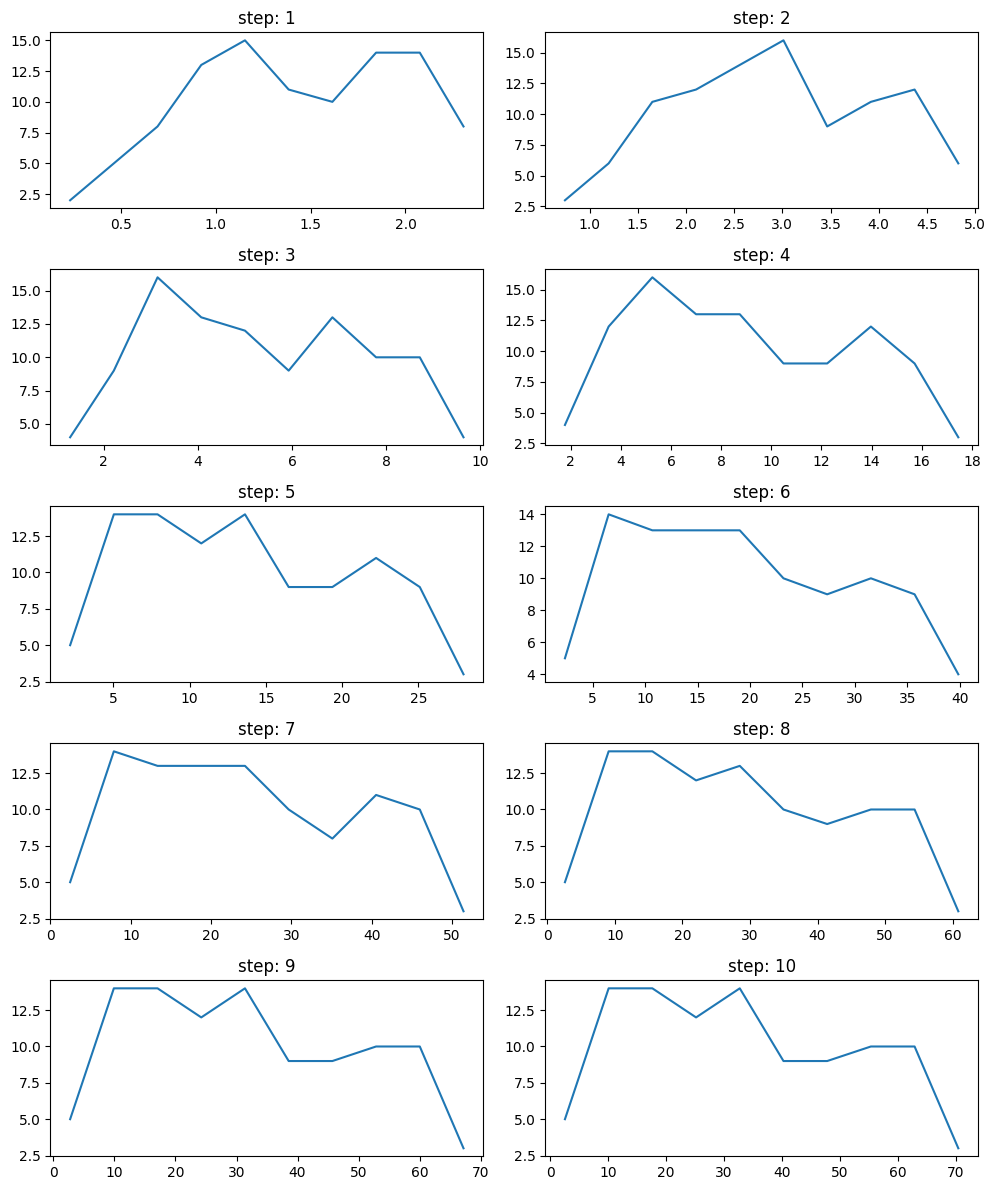

In [18]:
# Plot

plt.figure(figsize=(10, 12))
for i, gen_samples in enumerate(generated_samples):
    # x, bins = np.histogram(gen_samples, bins=np.linspace(-5, 5, 100, endpoint=False))
    x, bins = np.histogram(gen_samples)

    plt.subplot(5,2, i+1)
    plt.plot(bins[:-1], x)
    plt.title(f"step: {i+1}")

plt.tight_layout()
plt.show()

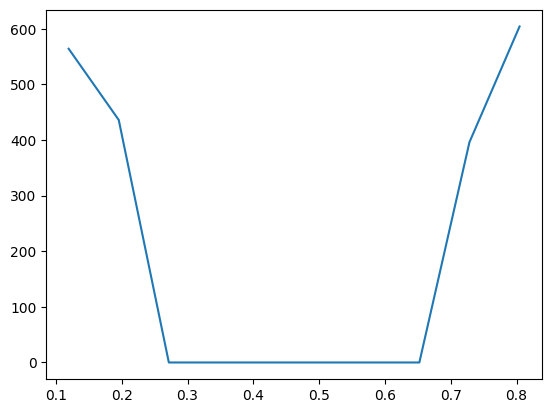

In [19]:
data_pool = F.sigmoid(torch.from_numpy(combined_samples)).numpy()

x, bins = np.histogram(data_pool)

plt.plot(bins[:-1], x)
plt.show()